### purpose

validation multivariate nuisance rda

In [2]:
from pythonimports import *
from myfigs import histo_box, adjust_box_widths

import MVP_03_validate_gradient_forests as mvp03
import MVP_15_climate_outlier_validate_GF as mvp15
import MVP_19_climate_outlier_validate_RDA as mvp19
import MVP_summary_functions as mvp

import seaborn as sns

lview, dview = get_client(cluster_id='1694097663-r97i', profile='lotterhos')

mvp19.lview = lview

outerdir = '/home/b.lind/offsets/run_20220919_nuisance/tutorial'
rda_dir = f'{outerdir}/rda'
mvp19.offset_dir = f'{rda_dir}/offset_outfiles'
assert all([op.exists(outerdir), op.exists(rda_dir)])
validation_dir = makedir(f'{rda_dir}/validation')

mvp.latest_commit()
session_info.show()

36 36
#########################################################
Today:	September 07, 2023 - 13:02:23 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 9493334506a1f2926fba0734fa74ba2f87194611  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Jun 30 09:41:00 2023 -0400

Current commit of MVP_offsets:
commit 34fec27ce185eb670eb16124a5255c9d4964ee70  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Sep 5 11:47:40 2023 -0400
#########################################################



# get pop data

In [5]:
inds = pd.read_table(f'/home/b.lind/offsets/run_20220919_tutorial/tutorial/My_Individuals.txt')

inds.head()

,ind_index,x,y,phenotype1_mat,phenotype2_MTWetQ,phenotype3_MTDQ,phenotype4_PDM,phenotype5_PwarmQ,phenotype6_PWM,env1_mat,env2_MTWetQ,env3_MTDQ,env4_PDM,env5_PwarmQ,env6_PWM,subpopID,lon,lat
0,33,0.406184,0.233272,0.737967,-0.191421,0.142992,-0.131894,-0.452497,-0.541651,0.762432,-0.162238,0.261281,-0.332078,-0.471502,-0.477821,25,5.0,3.0
1,34,0.425697,0.837158,-0.274081,-0.428332,-0.012880,0.221058,0.229296,0.066597,-0.339330,-0.407667,-0.058296,0.288030,0.198810,0.017680,85,5.0,9.0
2,44,0.671673,0.581744,-0.676326,0.086629,-0.470671,0.218813,0.260098,-0.103465,-0.567733,0.090928,-0.414353,0.234899,0.230255,-0.053511,57,7.0,6.0
3,45,0.017466,0.329922,-0.283221,-0.403942,-0.333718,-0.200554,-0.345915,-0.410001,-0.245860,-0.200759,-0.267455,-0.265260,-0.389828,-0.458979,31,1.0,4.0
4,46,0.069744,0.121221,0.057616,-0.303201,0.731600,0.195679,-0.367110,0.196296,-0.121500,-0.306379,0.702858,0.211275,-0.352307,0.212751,11,1.0,2.0


In [6]:
locations = inds.groupby('subpopID')[['lon', 'lat']].apply(np.mean)

locations

,lon,lat
subpopID,,
1,1.0,1.0
2,2.0,1.0
3,3.0,1.0
4,4.0,1.0
5,5.0,1.0
...,...,...
96,6.0,10.0
97,7.0,10.0
98,8.0,10.0


# read in offsets

In [7]:
outfiles = fs(mvp19.offset_dir, endswith='offset.txt')

assert len(outfiles) == 8  # 4 marker sets (TRUE, FALSE, NEUTRAL, CAUSAL) * 2 (structcorr or nocorr)

In [11]:
[gettimestamp(f) for f in outfiles]

['Thu Sep  7 12:25:24 2023',
 'Thu Sep  7 12:24:49 2023',
 'Thu Sep  7 12:25:15 2023',
 'Thu Sep  7 12:24:41 2023',
 'Thu Sep  7 12:25:33 2023',
 'Thu Sep  7 12:24:58 2023',
 'Thu Sep  7 12:25:41 2023',
 'Thu Sep  7 12:25:06 2023']

In [14]:
offset_dfs = mvp19.read_offset_dfs(outfiles)


Reading in offset dfs ...

Watching 8 jobs ...


100%|███████████████| 8/8 [00:00<00:00, 51072.19it/s]


In [15]:
offset = offset_dfs['tutorial']['pooled']['CAUSAL']['ntraits-9']['nocorr'].copy()

offset

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
1,0.000000,0.250376,0.854282,1.561747,1.256260,0.544031,0.282903,0.408094,0.404869,1.035158,0.307796,0.450632,1.005488,1.597158,1.082189,0.380762,0.745636,0.643167,0.867708,1.623392,0.777243,0.794289,1.246204,1.670262,0.846286,0.663855,1.020225,0.932905,1.556062,2.172585,1.453922,1.324370,1.689851,1.029146,0.619240,0.782333,1.143862,0.960944,1.974039,2.330184,2.278274,1.792583,1.828749,0.703875,0.583939,0.869075,1.163580,1.216903,2.329971,2.968596,2.694533,1.954810,1.829327,0.650672,0.656902,0.836485,1.159773,1.722617,2.676938,3.410942,2.735382,2.002314,0.895033,0.624508,0.727763,0.922051,1.759769,2.386930,3.374809,4.601533,2.648806,1.919429,1.417818,0.855317,0.830189,1.167372,2.474671,3.133770,3.956662,4.970012,2.363342,1.765927,1.032395,0.985208,0.824187,1.483352,2.668804,3.723390,4.562217,5.151304,2.143615,1.379741,1.097892,0.986371,1.408540,2.269518,3.301298,4.274190,5.009368,5.253803
2,0.250376,0.000000,0.671316,1.453708,1.158876,0.568440,0.393921,0.545111,0.461387,1.107432,0.276306,0.284711,0.880721,1.503328,0.975361,0.413541,0.943551,0.822991,0.965090,1.720348,0.747711,0.701030,1.096764,1.570714,0.735504,0.842005,1.224127,1.097616,1.633543,2.269166,1.458103,1.280491,1.620797,0.959896,0.582262,0.965574,1.343871,1.089140,2.075327,2.417510,2.281328,1.757204,1.798378,0.686249,0.638333,1.041193,1.350660,1.336990,2.439013,3.065967,2.703732,1.943758,1.826001,0.677307,0.747860,0.991407,1.293071,1.846008,2.791487,3.507802,2.754409,2.000161,1.014723,0.765840,0.860305,1.052517,1.880226,2.506559,3.477038,4.693494,2.672146,1.938128,1.500171,1.025650,0.964798,1.267120,2.587220,3.242134,4.052684,5.064020,2.388020,1.810834,1.183636,1.149507,0.942494,1.576950,2.775562,3.821658,4.658349,5.246496,2.160090,1.475170,1.235375,1.123260,1.506707,2.361818,3.390876,4.366824,5.109004,5.351964
3,0.854282,0.671316,0.000000,0.850914,0.617044,0.708724,1.024280,1.170141,0.772576,1.068732,0.623008,0.438851,0.342541,0.926216,0.444437,0.699905,1.361033,1.255231,1.077824,1.643962,0.589287,0.376088,0.444696,0.975173,0.303073,1.221638,1.590049,1.387072,1.510337,2.138212,1.153774,0.859158,1.085753,0.552283,0.524111,1.298519,1.718450,1.233882,1.983687,2.242757,1.877211,1.288206,1.339095,0.608278,0.773593,1.324599,1.658109,1.395995,2.342141,2.887674,2.293170,1.518157,1.430421,0.709801,0.899532,1.247532,1.404618,1.852165,2.692658,3.311188,2.366085,1.593223,1.135068,1.059097,1.109586,1.231857,1.883412,2.448485,3.299693,4.454848,2.297491,1.591597,1.391767,1.347973,1.191415,1.285832,2.495334,3.097181,3.837964,4.826336,2.029370,1.551582,1.374409,1.433594,1.128191,1.519634,2.648949,3.620350,4.431470,5.009250,1.791085,1.418670,1.362323,1.303941,1.479452,2.211134,3.174341,4.132663,4.886381,5.122207
4,1.561747,1.453708,0.850914,0.000000,0.336357,1.198736,1.755126,1.878206,1.347549,1.133288,1.295539,1.192040,0.593668,0.117109,0.498687,1.297532,1.811577,1.751474,1.323503,1.444865,0.900777,0.800041,0.437216,0.144493,0.743044,1.672083,1.935363,1.707125,1.286934,1.771395,0.803197,0.492455,0.311482,0.598447,1.009693,1.677738,2.057441,1.442166,1.697006,1.803018,1.177216,0.581167,0.636449,0.988636,1.207522,1.646717,1.931103,1.446504,1.995980,2.385782,1.555886,0.833325,0.810391,1.098048,1.267090,1.569151,1.515348,1.720134,2.308424,2.764344,1.649009,0.923482,1.350695,1.484218,1.478219,1.483562,1.744969,2.143378,2.776177,3.827719,1.599627,1.012241,1.220367,1.711833,1.508898,1.329937,2.139690,2.624488,3.250944,4.193562,1.371612,1.113773,1.584380,1.737754,1.428914,1.385629,2.232268,3.055514,3.816608,4.373933,1.146796,1.311077,1.502292,1.531111,1.398383,1.808805,2.610252,3.516528,4.267685,4.492804
5,1.256260,1.158876,0.617044,0.336357,0.000000,0.865710,1.437956,1.554179,1.017000,0.856879,0.97995

# read in fitness

In [16]:
mvp15.fitness_dir = '/home/b.lind/offsets/run_20220919_tutorial/tutorial/fitness_mats'
fitness = mvp15.get_fitness(
    ['tutorial'],
)['tutorial']

fitness.index = fitness.index.astype(int)

fitness = fitness.loc[sorted(fitness.index)]

fitness.index = fitness.index.astype(str)

fitness


Reading fitness matrices ...


100%|███████████████| 1/1 [00:00<00:00,  1.23it/s]


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
1,0.982222,0.924615,0.612,0.431,0.500000,0.660000,0.894444,0.878889,0.752667,0.731,0.862857,0.738889,0.49375,0.41500,0.568889,0.790833,0.809091,0.722,0.598182,0.608182,0.6625,0.598333,0.502857,0.422308,0.659167,0.781667,0.77250,0.618889,0.559231,0.532727,0.45625,0.472143,0.438,0.535556,0.705455,0.824286,0.690000,0.65875,0.483,0.526667,0.41750,0.461,0.496667,0.6425,0.732500,0.788571,0.709,0.616667,0.460,0.514286,0.42750,0.483,0.576364,0.723077,0.751818,0.75000,0.641429,0.524286,0.441538,0.483333,0.478462,0.522857,0.73250,0.742727,0.72000,0.666842,0.460,0.38375,0.45500,0.3875,0.48875,0.554000,0.616667,0.680000,0.669375,0.601818,0.410909,0.425714,0.432222,0.377778,0.498571,0.578,0.646,0.633846,0.669,0.529091,0.430,0.454444,0.419333,0.345,0.543333,0.620000,0.650000,0.656667,0.550000,0.483,0.474286,0.483077,0.388571,0.352308
2,0.965556,0.978462,0.748,0.576,0.641429,0.779167,0.906667,0.923333,0.863333,0.842,0.937143,0.868889,0.64625,0.55500,0.705556,0.859167,0.812727,0.780,0.715455,0.700000,0.8000,0.750000,0.648571,0.543077,0.779167,0.818333,0.75125,0.692222,0.667692,0.622727,0.59500,0.617143,0.569,0.678889,0.817273,0.834286,0.685833,0.74250,0.576,0.618889,0.55250,0.588,0.618889,0.7750,0.830000,0.815714,0.736,0.712000,0.542,0.592857,0.55125,0.601,0.679091,0.826154,0.840909,0.82000,0.714286,0.611429,0.520000,0.548889,0.606154,0.634286,0.78625,0.796364,0.79875,0.768947,0.547,0.46125,0.51625,0.4350,0.60625,0.653333,0.674667,0.730000,0.767500,0.710909,0.490909,0.491429,0.481111,0.420000,0.614286,0.662,0.685,0.703077,0.773,0.628182,0.511,0.511111,0.450667,0.377,0.655556,0.685789,0.696667,0.731111,0.640000,0.566,0.548571,0.520000,0.411429,0.379231
3,0.730000,0.825385,0.890,0.871,0.882857,0.874167,0.692222,0.695556,0.810667,0.789,0.827143,0.908889,0.92000,0.84000,0.912222,0.830833,0.642727,0.654,0.761818,0.700000,0.9200,0.952500,0.921429,0.803077,0.920000,0.691667,0.55250,0.637778,0.755385,0.656364,0.81250,0.874286,0.846,0.903333,0.891818,0.674286,0.520833,0.73250,0.642,0.685556,0.81000,0.830,0.840000,0.9175,0.860833,0.677143,0.593,0.706000,0.573,0.645714,0.80750,0.825,0.814545,0.874615,0.820000,0.74000,0.671429,0.618571,0.548462,0.598889,0.830000,0.820000,0.70250,0.705455,0.73000,0.746842,0.570,0.49375,0.55125,0.5100,0.78750,0.786000,0.655333,0.636667,0.743750,0.733636,0.541818,0.525714,0.518333,0.487778,0.800000,0.732,0.584,0.630000,0.770,0.662727,0.571,0.545556,0.476000,0.434,0.811111,0.646316,0.600000,0.686667,0.663333,0.620,0.612857,0.534615,0.444286,0.434615
4,0.496667,0.587692,0.800,0.964,0.927143,0.744167,0.468889,0.453333,0.616000,0.635,0.612857,0.747778,0.90750,0.97625,0.890000,0.650833,0.445455,0.459,0.630909,0.606364,0.7975,0.871667,0.928571,0.943077,0.814167,0.496667,0.37125,0.481111,0.697692,0.594545,0.81875,0.917143,0.976,0.896667,0.756364,0.465714,0.352500,0.58000,0.605,0.653333,0.93500,0.946,0.933333,0.8125,0.703333,0.482857,0.411,0.571333,0.527,0.621429,0.95125,0.931,0.850909,0.718462,0.640000,0.55625,0.520000,0.517143,0.506923,0.594444,0.923846,0.888571,0.54875,0.523636,0.54000,0.574211,0.502,0.46125,0.53500,0.5450,0.85750,0.816667,0.570667,0.462222,0.572500,0.605455,0.523636,0.502857,0.512222,0.513333,0.870000,0.712,0.424,0.460000,0.606,0.591818,0.562,0.536667,0.481333,0.465,0.854444,0.532632,0.428333,0.526667,0.601111,0.597,0.620000,0.517692,0.451429,0.465385
5,0.557778,0.651538,0.836,0.956,0.948571,0.830833,0.542222,0.531111,0.698667,0.732,0.680000,0.807778,0.94250,0.96250,0.916667,0.727500,0.533636,0.558,0.728182,0.710909,0.8750,0.918333,0.921429,0.910769,0.859167,0.595833,0.46000,0.590000,0.799231,0.703636,0.88875,0.947857,0.967,0.944444,0.830909,0.554286,0.444167,0.67625,0.713,0.757778,0.95500,0.954,0.947778,0.8800,0.781667,0.5

# calculate validation scores

In [17]:
vmin = math.inf
vmax = -math.inf

validation = pd.DataFrame(
    columns=['seed', 'ind_or_pooled', 'use_RDA_outliers', 'ntraits', 'structcorr', 'garden', 'score']
)

heatmaps = wrap_defaultdict(lambda: mvp03.blank_dataframe(), 2)
for (seed, ind_or_pooled, marker_set, ntraits, structcorr), offset in unwrap_dictionary(offset_dfs):
    corrs = offset.corrwith(fitness, axis=1, method='kendall')
    
    for subpopID, corr in corrs.items():
        lon, lat = locations.loc[int(subpopID)]
        heatmaps[marker_set][structcorr].loc[lon, lat] = corr
        
        if corr < vmin:
            vmin = corr
        if corr > vmax:
            vmax = corr
            
        validation.loc[nrow(validation), :] = ('tutorial',
                                               'pooled',
                                               marker_set,
                                               ntraits,
                                               structcorr,
                                               subpopID,
                                               corr)
        
validation['marker_set'] = validation.use_RDA_outliers.map({'TRUE': 'rda_outliers',
                                                            'FALSE': 'all',
                                                            'CAUSAL': 'adaptive',
                                                            'NEUTRAL': 'neutral'
                                                           })
validation.pop('use_RDA_outliers')
validation['program'] = 'rda-' + validation['structcorr']

In [18]:
validation.score.isnull().sum()

0

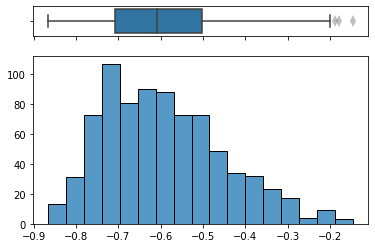

(<AxesSubplot:>, <AxesSubplot:>)

In [19]:
histo_box(validation.score)

# visualize

In [20]:
def show_heatmaps(vmin=None, vmax=None):
    axes = []
    for (marker_set, structcorr), heatmap in unwrap_dictionary(heatmaps):
        g = sns.heatmap(heatmap,
                        vmin=vmin,
                        vmax=vmax,
                        cmap='viridis',
                        cbar_kws={'label': "Kendall's $\\tau$"})

        g.set(title=f'{marker_set} {structcorr}')

        g.figure.axes[-1].yaxis.label.set_size(15)

        plt.show()

        axes.append(g.figure.axes[0])
    
    return axes

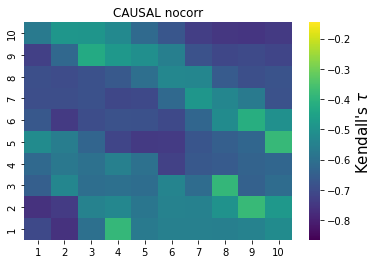

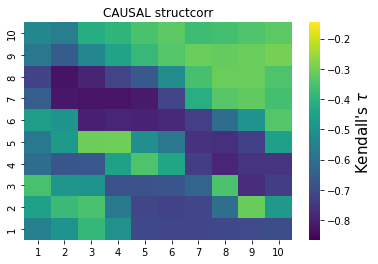

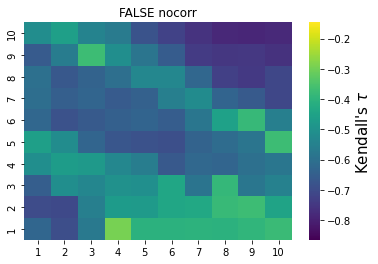

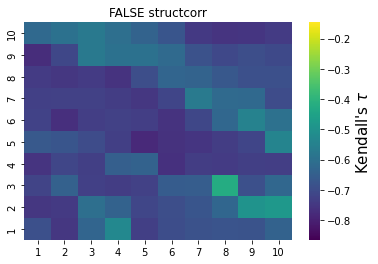

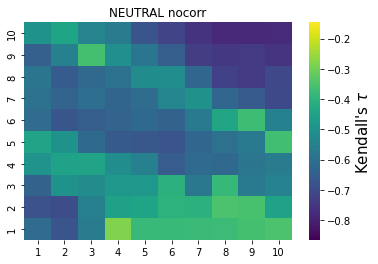

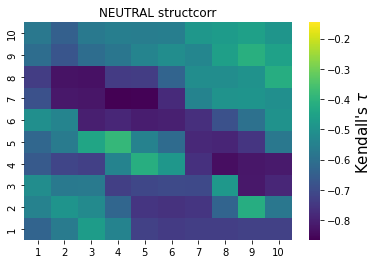

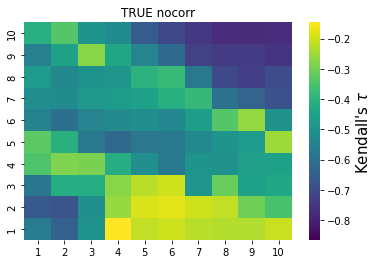

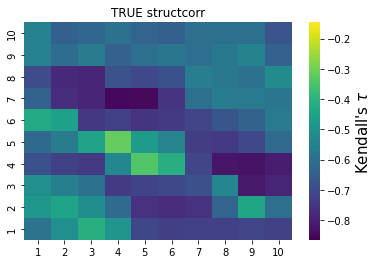

[<AxesSubplot:title={'center':'CAUSAL nocorr'}>,
 <AxesSubplot:title={'center':'CAUSAL structcorr'}>,
 <AxesSubplot:title={'center':'FALSE nocorr'}>,
 <AxesSubplot:title={'center':'FALSE structcorr'}>,
 <AxesSubplot:title={'center':'NEUTRAL nocorr'}>,
 <AxesSubplot:title={'center':'NEUTRAL structcorr'}>,
 <AxesSubplot:title={'center':'TRUE nocorr'}>,
 <AxesSubplot:title={'center':'TRUE structcorr'}>]

In [21]:
show_heatmaps(vmin=vmin, vmax=vmax)

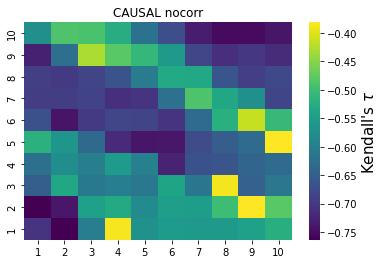

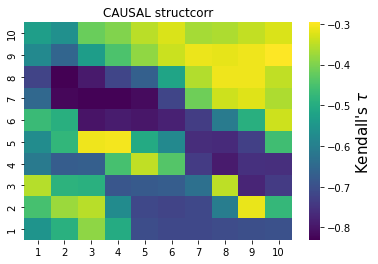

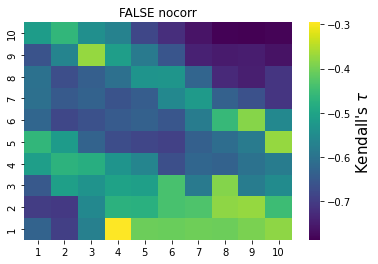

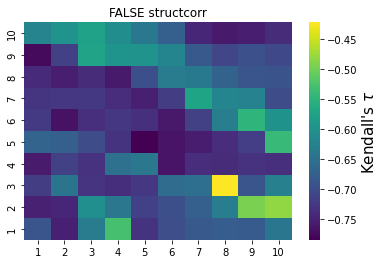

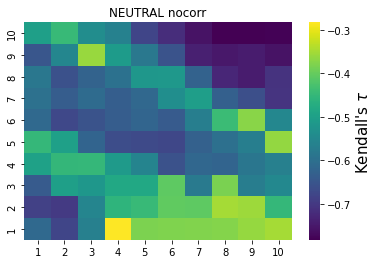

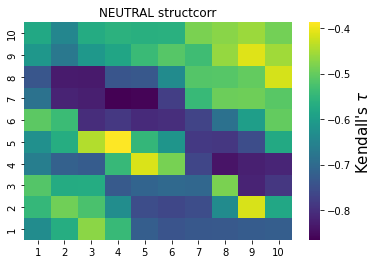

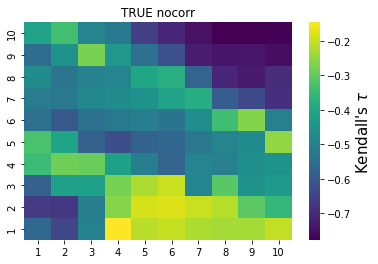

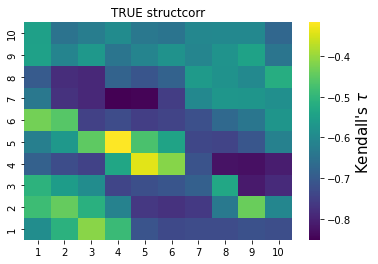

[<AxesSubplot:title={'center':'CAUSAL nocorr'}>,
 <AxesSubplot:title={'center':'CAUSAL structcorr'}>,
 <AxesSubplot:title={'center':'FALSE nocorr'}>,
 <AxesSubplot:title={'center':'FALSE structcorr'}>,
 <AxesSubplot:title={'center':'NEUTRAL nocorr'}>,
 <AxesSubplot:title={'center':'NEUTRAL structcorr'}>,
 <AxesSubplot:title={'center':'TRUE nocorr'}>,
 <AxesSubplot:title={'center':'TRUE structcorr'}>]

In [22]:
show_heatmaps()

In [23]:
mvp.boxplot_kwargs['palette'].update({'rda_outliers' : 'white'})

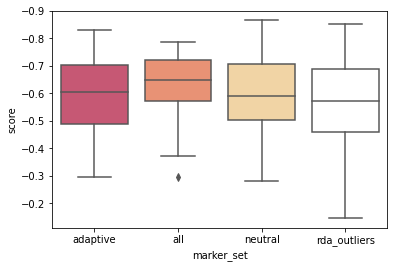

In [24]:
g = sns.boxplot(data=validation,
                x='marker_set',
                y='score',
                palette=mvp.boxplot_kwargs['palette']
               )

g.axes.invert_yaxis()

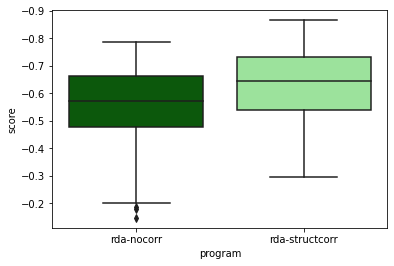

In [25]:
g = sns.boxplot(data=validation,
                x='program',
                y='score',
                palette=mvp.boxplot_kwargs['palette']
               )

g.axes.invert_yaxis()

In [26]:
def make_scatter(m1, m2, validation):
    fig, ax = plt.subplots()
    
    m1_df = validation[validation.marker_set == m1].copy().reset_index(drop=True)
    m2_df = validation[validation.marker_set == m2].copy().reset_index(drop=True)
    
    print(nrow(m1_df), nrow(m2_df))
    
    ax.scatter(m1_df['score'],
               m2_df['score'])

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    ax.set_xlabel(m1)
    ax.set_ylabel(m2)
    
    
    perc = (m1_df.score <= m2_df.score).sum() / nrow(m1_df)
    perc = '{:.0f}'.format(perc*100)
    ax.set_title(f'{perc}% of {m1} scores are ≤ {m2} scores')
    
    ax.invert_yaxis()
    ax.invert_xaxis()
    
    
    plt.show()
    
    pass

### RDA-uncorrected scatterplots

100 100


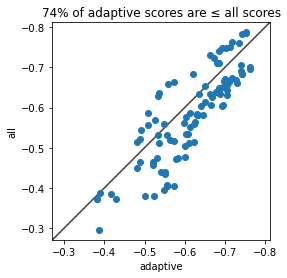

100 100


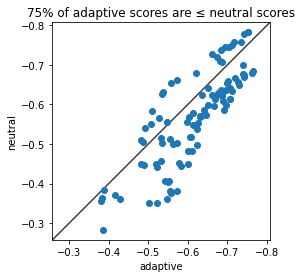

100 100


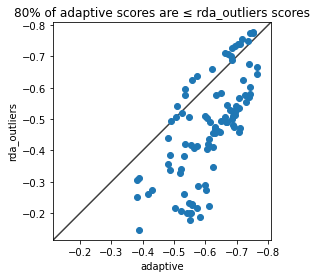

100 100


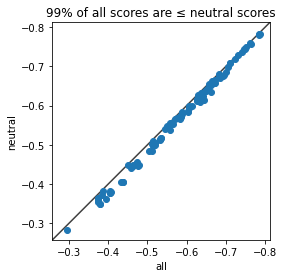

100 100


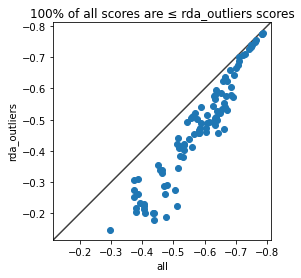

100 100


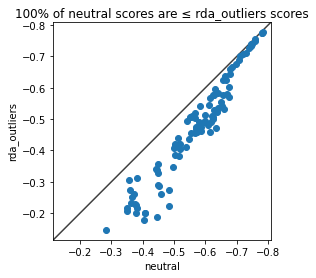

In [29]:
for marker_set1, marker_set2 in it.combinations(validation.marker_set.unique(), r=2):
    make_scatter(marker_set1, marker_set2, validation[validation.program=='rda-nocorr'])

100 100


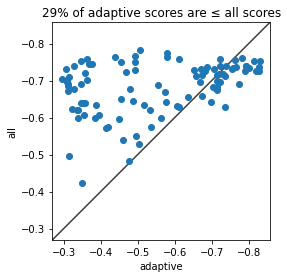

100 100


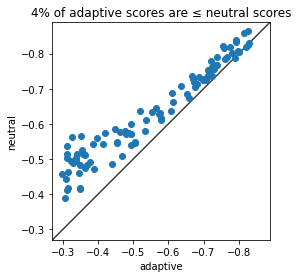

100 100


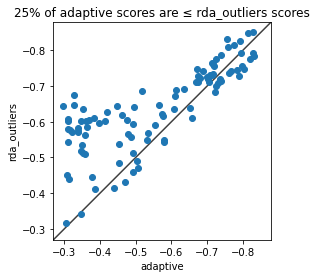

100 100


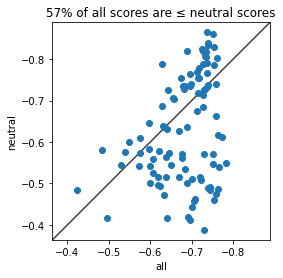

100 100


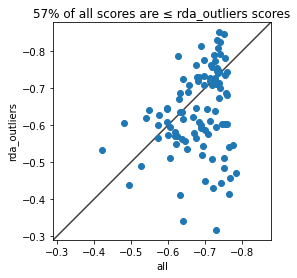

100 100


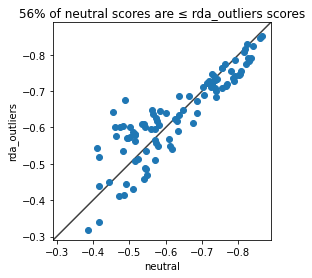

In [30]:
for marker_set1, marker_set2 in it.combinations(validation.marker_set.unique(), r=2):
    make_scatter(marker_set1, marker_set2, validation[validation.program=='rda-structcorr'])

# save

In [31]:
validation_dir

'/home/b.lind/offsets/run_20220919_nuisance/tutorial/rda/validation'

In [32]:
f = op.join(validation_dir, 'tutorial_validation_scores.txt')

validation.to_csv(f, sep='\t', index=False, header=True)

# compare nuis vs reg

In [34]:
nuis = validation.copy()
reg = pd.read_table('/home/b.lind/offsets/run_20220919_tutorial/rda/validation/tutorial_validation_scores.txt')

reg.head()

,seed,ind_or_pooled,ntraits,structcorr,garden,score,marker_set,program
0,tutorial,pooled,ntraits-6,nocorr,1,-0.702244,adaptive,rda-nocorr
1,tutorial,pooled,ntraits-6,nocorr,2,-0.757074,adaptive,rda-nocorr
2,tutorial,pooled,ntraits-6,nocorr,3,-0.770040,adaptive,rda-nocorr
3,tutorial,pooled,ntraits-6,nocorr,4,-0.670438,adaptive,rda-nocorr
4,tutorial,pooled,ntraits-6,nocorr,5,-0.672325,adaptive,rda-nocorr


In [35]:
from myfigs import draw_xy

adaptive

RDA-uncorrected 93

RDA-corrected 59


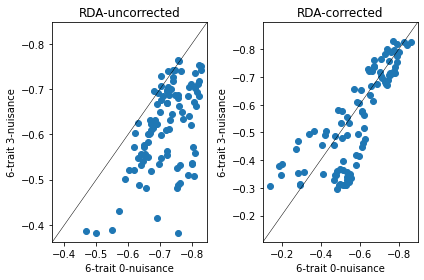

all

RDA-uncorrected 59

RDA-corrected 100


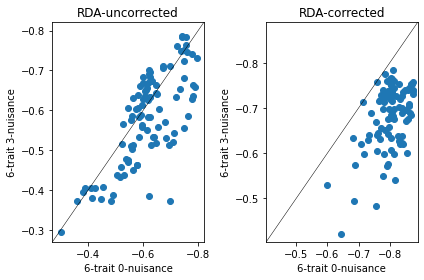

neutral

RDA-uncorrected 57

RDA-corrected 53


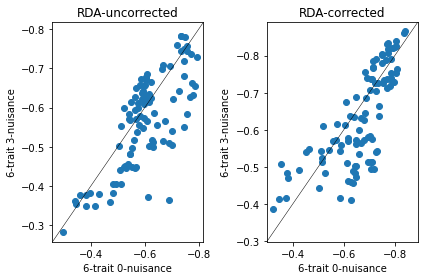

rda_outliers

RDA-uncorrected 51

RDA-corrected 42


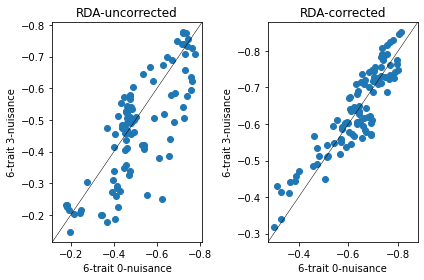

In [54]:
for marker_set in reg.marker_set.unique():
    print(ColorText(marker_set).bold()
         )
    fig, axes = plt.subplots(ncols=2)
    
    for i, program in enumerate(reg.program.unique()):
        reg_df = reg[(reg.marker_set == marker_set) & (reg.program == program)].copy()
        nuis_df = nuis[(nuis.marker_set == marker_set) & (nuis.program == program)].copy()
    
        ax = axes[i]
        
        ax.scatter(reg_df.score, nuis_df.score)
        ax.set_xlabel('6-trait 0-nuisance')
        ax.set_ylabel('6-trait 3-nuisance')
        draw_xy(ax)
        ax.set_title(mvp.factor_names[program])
        ax.invert_yaxis()
        ax.invert_xaxis()
    
        print(f'\n{mvp.factor_names[program]}', sum(reg_df.score <= nuis_df.score))
        
    plt.tight_layout()
    plt.show()